# Women's World Cup


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.core.display import display, HTML

import plots as ps

sns.set()
sns.set_palette("GnBu_d", 6)
%matplotlib inline

def create_link(id):
    display(HTML(f'<a id={id}></a>'))


## Analysing Data

In [2]:
scores_raw = pd.read_csv('womens_world_cup_data.csv')
ranking = pd.read_csv('womens_world_cup_rankings.csv')

display(scores_raw.shape)
display(ranking.shape)

(354, 7)

(150, 3)

In [3]:
scores_raw.head(3)

,Team_i,Team_j,home_i,home_j,score_i,score_j,year
0,china,thailand,0,0,4,0,2018
1,jordan,philippines,1,0,1,2,2018
2,philippines,china,0,0,0,3,2018


In [4]:
ranking.head(3)

,rank,team,rating
0,1,United States,2101
1,2,Germany,2072
2,3,England,2049


In [5]:
scores = scores_raw.drop(columns=['home_i', 'home_j'])
display(scores.info())
display(scores.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 5 columns):
Team_i     354 non-null object
Team_j     354 non-null object
score_i    354 non-null int64
score_j    354 non-null int64
year       354 non-null int64
dtypes: int64(3), object(2)
memory usage: 13.9+ KB


None

,Team_i,Team_j,score_i,score_j,year
0,china,thailand,4,0,2018
1,jordan,philippines,1,2,2018
2,philippines,china,0,3,2018
3,thailand,jordan,6,1,2018
4,jordan,china,1,8,2018


In [6]:
ranking.team = ranking.team.apply(lambda x: x.lower())
ranking.head(3)

,rank,team,rating
0,1,united states,2101
1,2,germany,2072
2,3,england,2049


### Guarantee that team I and team J respect lexical order

In [7]:
scores.loc[scores['Team_j'] < scores['Team_i'], ['Team_i', 'score_i', 'Team_j', 'score_j']] = \
    scores.loc[scores['Team_j'] < scores['Team_i'], ['Team_j', 'score_j', 'Team_i', 'score_i']].values
        

scores.head()

,Team_i,Team_j,score_i,score_j,year
0,china,thailand,4,0,2018
1,jordan,philippines,1,2,2018
2,china,philippines,3,0,2018
3,jordan,thailand,1,6,2018
4,china,jordan,8,1,2018


### Merging DataFrames

In [8]:
all_matches_i_j = (scores.merge(ranking, left_on='Team_i', right_on='team')
                         .rename(columns={'Team_i': 'team_i',
                                          'rating': 'rating_i',
                                          'rank': 'rank_i'})
                         .drop(columns=['team'])
                         .merge(ranking, left_on='Team_j', right_on='team')
                         .rename(columns={'Team_j': 'team_j',
                                          'rating': 'rating_j',
                                          'rank': 'rank_j'})
                         .drop(columns=['team']))


all_matches = all_matches_i_j.rename(columns={'team_i': 'team_a',
                                              'score_i': 'score_a',
                                              'rank_i': 'rank_a',
                                              'rating_i': 'rating_a',
                                              'team_j': 'team_b',
                                              'score_j': 'score_b',
                                              'rank_j': 'rank_b',
                                              'rating_j': 'rating_b',})

all_matches.head()

,team_a,team_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
0,china,thailand,4,0,2018,16,1866,34,1658
1,china,thailand,3,1,2018,16,1866,34,1658
2,jordan,thailand,1,6,2018,54,1440,34,1658
3,philippines,thailand,1,3,2018,74,1347,34,1658
4,australia,thailand,2,2,2018,6,2003,34,1658


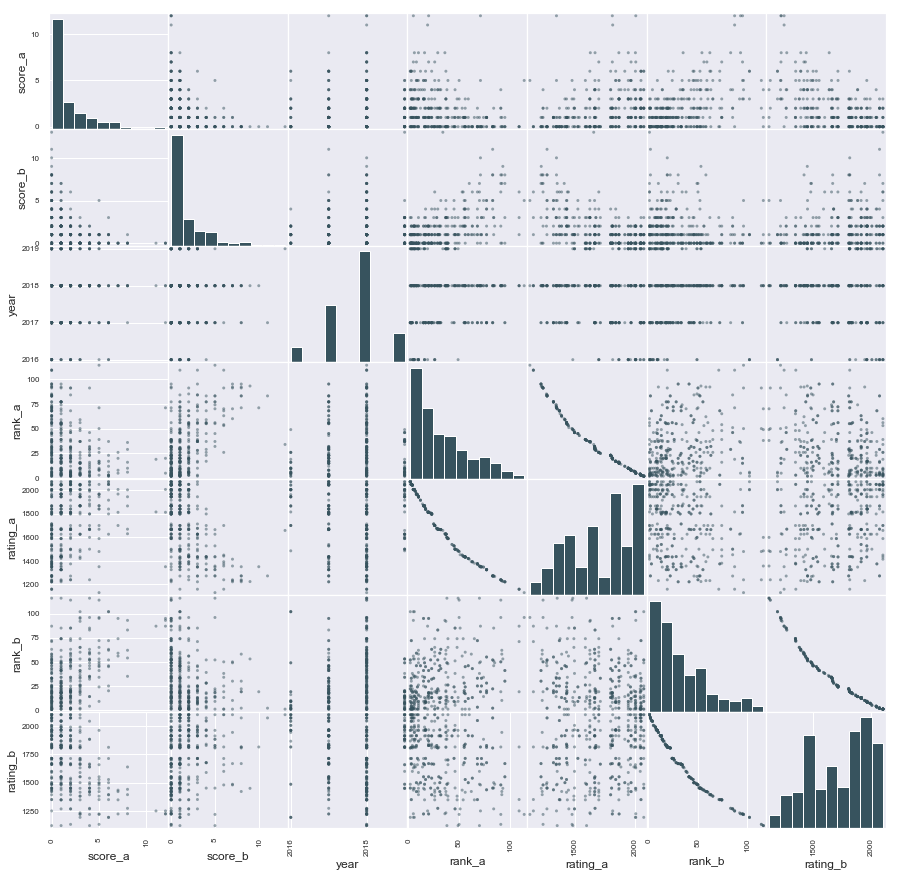

In [9]:
pd.plotting.scatter_matrix(all_matches, figsize=(15,15));

Some points:

countries with more rating play more games. as we can see in `rating_i X rating_i` *(equal to rank_i, rating_j and rank_j)*

There are more games at 2018.

There are some correlations between scores of A and rating that 

In [10]:
all_matches.sample(2, random_state=23)

,team_a,team_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
334,czech republic,iceland,1,1,2017,29,1669,22,1806
286,norway,slovakia,6,1,2017,12,1915,46,1499


# Model - Preprocess

For this first model we want to predict which team wons the match.

So, for that we are going to create a column target which says which one wins.

In [11]:
all_matches['target'] = 'draw'
all_matches.loc[all_matches.score_a > all_matches.score_b, ['target']] = 'win_a'
all_matches.loc[all_matches.score_a < all_matches.score_b, ['target']] = 'win_b'
print(f"amount of target values: {all_matches['target'].nunique()}")

amount of target values: 3


In [12]:
for c in all_matches.columns:
    print(f'{c} = {all_matches[c].unique()} \n')

team_a = ['china' 'jordan' 'philippines' 'australia' 'chile' 'sweden' 'argentina'
 'brazil' 'england' 'nigeria' 'equatorial guinea' 'mali' 'germany'
 'south africa' 'russia' 'netherlands' 'denmark' 'croatia' 'hungary'
 'italy' 'canada' 'czech republic' 'faroe islands' 'france' 'scotland'
 'portugal' 'austria' 'israel' 'finland' 'serbia' 'japan' 'new zealand'
 'norway' 'south korea' 'panama' 'mexico' 'trinidad' 'jamaica' 'colombia'
 'thailand' 'albania' 'belarus' 'poland' 'cameroon' 'bolivia'
 'new caledonia' 'cook islands' 'fiji' 'belgium' 'costa rica' 'cuba'
 'algeria' 'ghana' 'ireland' 'northern ireland' 'paraguay' 'peru'
 'ecuador' 'bosnia and herzegovina' 'papua new guinea' 'samoa'
 'kazakhstan' 'moldova' 'iceland'] 

team_b = ['thailand' 'philippines' 'jordan' 'japan' 'south africa' 'sweden'
 'germany' 'spain' 'south korea' 'vietnam' 'united states' 'scotland'
 'canada' 'zimbabwe' 'brazil' 'new zealand' 'italy' 'jamaica' 'ghana'
 'cameroon' 'mali' 'nigeria' 'netherlands' 'zambia' 

We defined ratings as continuous variable and all others are going to be categorical.

In [13]:
X_raw = all_matches.drop(columns=['target', 'score_a', 'score_b'])
y_raw = all_matches['target']

display(X_raw.shape)
display(X_raw.sample(3, random_state=13))

display(y_raw.shape)
display(y_raw.sample(3, random_state=13))

(354, 7)

,team_a,team_b,year,rank_a,rating_a,rank_b,rating_b
259,italy,portugal,2017,15,1868,30,1668
245,kazakhstan,russia,2018,72,1349,25,1713
99,france,united states,2016,4,2043,1,2101


(354,)

259    win_a
245    win_b
99     win_b
Name: target, dtype: object

### Features

In [14]:
# enconding categorical features with one hot encoder
feat_cats = (pd.get_dummies(X_raw[['team_a',
                                   'team_b', 'year']].astype(str)))
print('shape categorycal:')
display(feat_cats.shape)

# normalization numerical features
from sklearn import preprocessing

feat_nums_raw = preprocessing.scale(X_raw[['rating_a', 'rating_b']])
feat_nums = pd.DataFrame(feat_nums_raw, columns=['rating_a', 'rating_b'])
print('describe numerical:')
display(feat_nums.describe())

# merging data
X = feat_nums.join(feat_cats)
print('shape all merged:')
display(X.shape)

shape categorycal:


(354, 134)

describe numerical:


,rating_a,rating_b
count,3.540000e+02,3.540000e+02
mean,-4.014366e-17,3.211493e-16
std,1.001415e+00,1.001415e+00
min,-2.198113e+00,-2.267244e+00
25%,-8.723496e-01,-8.726298e-01
50%,1.655783e-02,1.752364e-01
75%,9.624465e-01,7.658519e-01
max,1.380309e+00,1.474590e+00


shape all merged:


(354, 136)

## The Model - First Scene

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_raw, test_size=0.20, random_state=37)

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=37)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=37, splitter='best')

#### Feature importance based on decision tree model

In [17]:
feature_importance = zip(X.columns, dt_model.feature_importances_)

for f, importance in sorted(feature_importance, key=lambda x: x[1], reverse=True):
    if importance > 0:
        print(f, importance)

rating_a 0.2915447657833164
rating_b 0.26683423030656606
year_2018 0.07180263847514018
year_2017 0.03612247726162082
team_b_colombia 0.01981025259318427
team_b_japan 0.015875783490220122
team_b_trinidad 0.013888082872635599
team_a_new caledonia 0.013357289369630446
team_a_england 0.011526354108026283
team_a_fiji 0.011514904628991785
team_a_brazil 0.011352778567937974
year_2016 0.010320707789034522
team_b_switzerland 0.010066376061376175
team_b_norway 0.009892542202740204
team_a_south africa 0.009606197249793669
team_a_portugal 0.00928863701013107
team_a_bolivia 0.009194812393867116
team_b_tahiti 0.009061581438772306
team_b_france 0.008979514361377372
team_a_japan 0.008441252581136673
team_a_northern ireland 0.008395263490052585
team_a_poland 0.008343477454714211
team_a_canada 0.008315541704307818
team_a_colombia 0.008256566231227617
team_b_chile 0.008256566231227617
team_b_new zealand 0.008256566231227617
team_a_scotland 0.006574030675704345
team_a_mexico 0.005772987041600325
team_a_de

In [18]:
pred = dt_model.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.6197183098591549

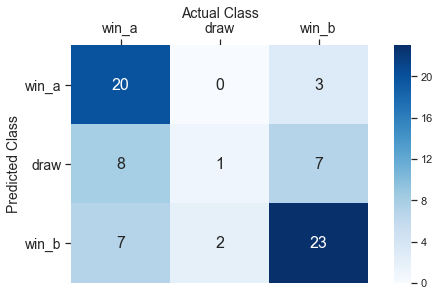

In [20]:
from sklearn.metrics import confusion_matrix
labels=['win_a', 'draw', 'win_b']
cm=confusion_matrix(y_test, pred, labels=labels)
ps.print_confusion_matrix(cm, labels)